# Logistic Regression model for Deepfake_Text_Detect

This notebook consists of the code for the training and evaluation of a logistic regression model for a subset of deepfake text detection on the benchmark dataset Deepfake_Text_Detect obtained from the url: https://huggingface.co/datasets/yaful/DeepfakeTextDetect

The Dataset consists of 1,13,611 samples with a distribution of:
* Deepfake text samples: 56,071 (49.39 %)
* Human text samples: 57,540 (50.61 %)

**The model trained in here is very basic and more optimiztions by tokenizations, Linguistic Parameters, etc. needs to be added so as to make the model more accurate and powerful. It also will be trained on a larger dataset in conjunction to this so as to increase the accuracy as well as other parameters of the model.**

## 1. Importing the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import nltk
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import train_test_split, learning_curve, validation_curve
from sklearn.model_selection import LearningCurveDisplay, ValidationCurveDisplay
import string
import itertools
import warnings

In [2]:
warnings.filterwarnings(action="ignore")

## 2. Data Importing and Visualization

In [3]:
data = pd.read_csv("data/dataset.csv")
data.drop("Unnamed: 0", axis=1, inplace=True)
print(data.shape)
data.head()

(113611, 2)


,text,label
0,Little disclaimer: this deals with US laws and...,1
1,"Read: Mentally Retarded Downs. See, we've got ...",1
2,"If any of you frequent rbadhistory, there is a...",1
3,"I believe in a flat tax system, where everyone...",1
4,"Edit: Ok guy's, my views have been changed on ...",1


In [4]:
print("Samples of Deepfake Content: {}".format(len(data[data["label"] == 0])))
print("Samples of Human Content: {}".format(len(data[data["label"] == 1])))

Samples of Deepfake Content: 56071
Samples of Human Content: 57540


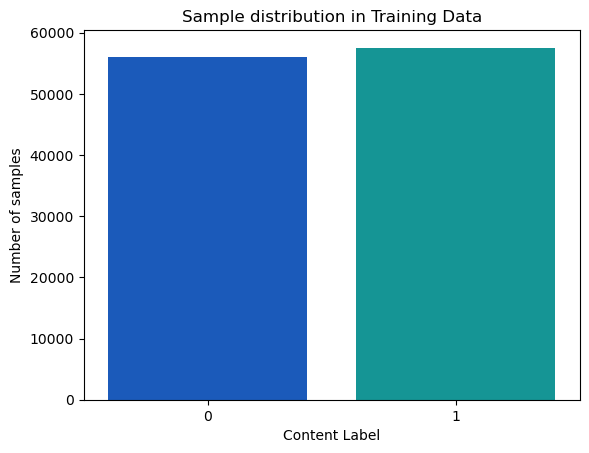

In [5]:
ax = sns.countplot(data=data, x="label", palette="winter")
ax.set_xlabel("Content Label")
ax.set_ylabel("Number of samples")
ax.set_title("Sample distribution in Training Data");

**The above distribution shows that we have a fairly balanced dataset for both the classes**

## 3. Basic preprocessing of the data using nltk

The preprocessing is done by using the nltk library by the following methodology:
* Converts text to lowercase
* Removes punctuation 
* Removes stopwords (ie., words that don’t add much meaning to a sentence and can be safely ignored)

In [6]:
nltk.download('stopwords')
stop = stopwords.words('english')
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].str.replace('[{}]'.format(string.punctuation), '')
data['text'] = data['text'].str.replace('\n','')
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
data.head()

[nltk_data] Downloading package stopwords to C:\Users\SRIRAMA
[nltk_data]     BHAT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,label
0,little disclaimer deals us laws procedures apo...,1
1,read mentally retarded downs see weve got peop...,1
2,frequent rbadhistory rather infamous chart cap...,1
3,believe flat tax system everyone pays percenta...,1
4,edit ok guys views changed subject reason esse...,1


In [7]:
X = data.drop("label", axis=1)
y = data["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train Shapes: ", X_train.shape, y_train.shape)
print("Test Shapes: ", X_test.shape, y_test.shape)

Train Shapes:  (90888, 1) (90888,)
Test Shapes:  (22723, 1) (22723,)


In [40]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## 4. Convert the preprocessed text into numerical format

**The model is created only by considering the Tf-Idf values for now. More features will be considered during optimization**

In [9]:
vectorizer = TfidfVectorizer(max_features=1000)

In [10]:
vectorizer.fit(X_train["text"])
X_train_transformed = vectorizer.transform(X_train["text"])
X_train_transformed

<90888x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 3622520 stored elements in Compressed Sparse Row format>

In [11]:
vectorizer.vocabulary_

{'dr': 230,
 'said': 744,
 'wales': 940,
 'bill': 89,
 'passed': 626,
 'last': 464,
 'week': 956,
 'vote': 937,
 'added': 17,
 'better': 86,
 'meant': 531,
 'people': 629,
 'would': 986,
 'get': 348,
 'say': 748,
 'lives': 495,
 'due': 234,
 'years': 993,
 'leading': 470,
 'church': 141,
 'tax': 865,
 'energy': 255,
 'reduce': 714,
 'told': 894,
 'matter': 526,
 'reached': 701,
 'point': 650,
 'yet': 995,
 'far': 293,
 'question': 691,
 'asked': 62,
 'needed': 578,
 'go': 357,
 'faster': 295,
 'course': 185,
 'dont': 228,
 'believe': 84,
 'hand': 378,
 'thing': 879,
 'well': 959,
 'given': 353,
 'moment': 554,
 '20': 4,
 'good': 363,
 'government': 366,
 'number': 594,
 'things': 880,
 'much': 565,
 'two': 911,
 'gone': 362,
 'including': 426,
 'big': 88,
 'test': 872,
 'walked': 942,
 'sat': 745,
 'started': 827,
 'tried': 904,
 'look': 502,
 'noticed': 593,
 'sent': 766,
 'didnt': 216,
 'take': 857,
 'project': 682,
 'space': 812,
 'book': 95,
 'even': 268,
 'getting': 350,
 'help': 

In [12]:
X_train_transformed.toarray()
X_train_transformed

<90888x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 3622520 stored elements in Compressed Sparse Row format>

In [13]:
X_train_transformed.shape

(90888, 1000)

In [14]:
y_train.shape

(90888,)

#### Transform the testing data
The testing data is transformed by the vectorizer that is fit on the training data

In [30]:
X_test_transformed = vectorizer.transform(X_test["text"])
X_test_transformed

<22723x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 899970 stored elements in Compressed Sparse Row format>

In [31]:
X_test_transformed.toarray()
X_test_transformed.shape

(22723, 1000)

In [17]:
train_size_abs, train_scores, test_scores = learning_curve(LogisticRegression(), X_train_transformed, y_train, 
                                                           train_sizes=[0.3, 0.4, 0.6, 0.8, 0.9, 0.95])
for train_size, cv_train_scores, cv_test_scores in zip(train_size_abs, train_scores, test_scores):
    print(f"{train_size} samples were used to train the model")
    print(f"The average train accuracy is {cv_train_scores.mean():.2f}")
    print(f"The average test accuracy is {cv_test_scores.mean():.2f}")

21813 samples were used to train the model
The average train accuracy is 0.70
The average test accuracy is 0.66
29084 samples were used to train the model
The average train accuracy is 0.70
The average test accuracy is 0.66
43626 samples were used to train the model
The average train accuracy is 0.69
The average test accuracy is 0.67
58168 samples were used to train the model
The average train accuracy is 0.69
The average test accuracy is 0.67
65439 samples were used to train the model
The average train accuracy is 0.69
The average test accuracy is 0.67
69074 samples were used to train the model
The average train accuracy is 0.69
The average test accuracy is 0.67


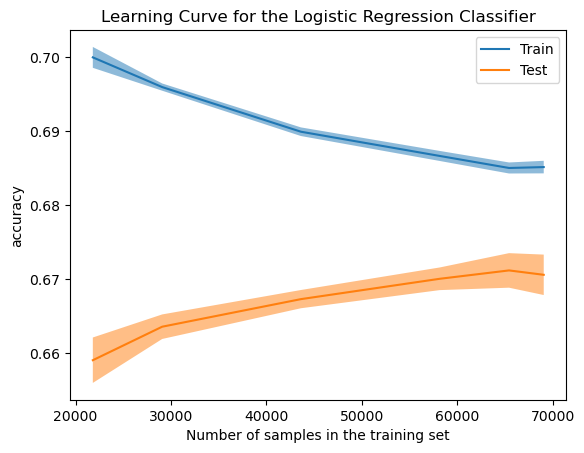

In [23]:
display = LearningCurveDisplay(train_sizes=train_size_abs, 
                               train_scores=train_scores, test_scores=test_scores, score_name="accuracy")
display.plot()
plt.title("Learning Curve for the Logistic Regression Classifier")
plt.show()

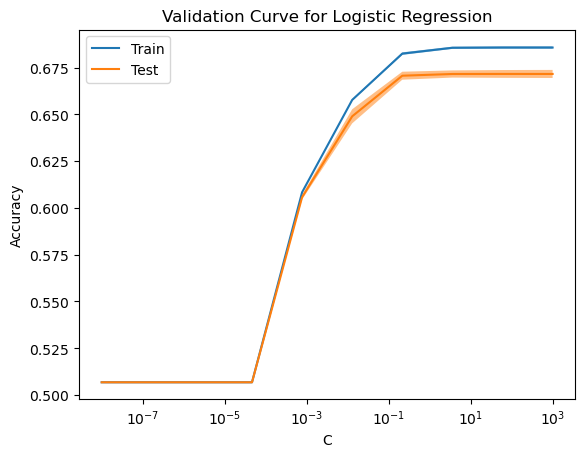

In [27]:
train_scores, test_scores = validation_curve(LogisticRegression(), X_train_transformed, y_train, 
                                             param_name="C", param_range=np.logspace(-8, 3, 10), scoring="accuracy")
display = ValidationCurveDisplay(
    param_name="C",
    param_range=np.logspace(-8, 3, 10),
    train_scores=train_scores,
    test_scores=test_scores,
    score_name="Accuracy"
)
display.plot()
plt.title("Validation Curve for Logistic Regression")
plt.show()

In [28]:
model = LogisticRegression()
model.fit(X_train_transformed, y_train)

LogisticRegression()

In [52]:
y_test

86658     1
15280     0
37947     1
72263     0
62256     0
         ..
112080    1
63653     0
97177     1
48160     1
18000     0
Name: label, Length: 22723, dtype: int64

In [33]:
y_preds = model.predict(X_test_transformed)
y_preds

array([1, 0, 1, ..., 1, 1, 0], dtype=int64)

In [38]:
print(classification_report(y_test, y_preds, target_names=["Deepfake", "Human"]))

              precision    recall  f1-score   support

    Deepfake       0.67      0.66      0.66     11247
       Human       0.67      0.69      0.68     11476

    accuracy                           0.67     22723
   macro avg       0.67      0.67      0.67     22723
weighted avg       0.67      0.67      0.67     22723



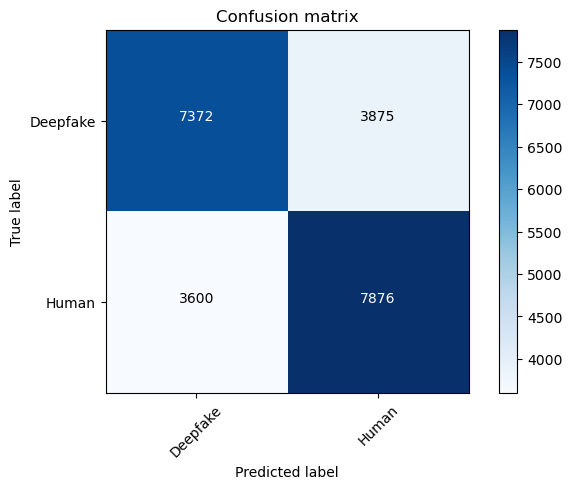

In [41]:
cm = confusion_matrix(y_test, y_preds)
plot_confusion_matrix(cm, classes=['Deepfake', 'Human'])

In [45]:
print("Accuracy Score: ", accuracy_score(y_test, y_preds)*100)

Accuracy Score:  67.10381551731726


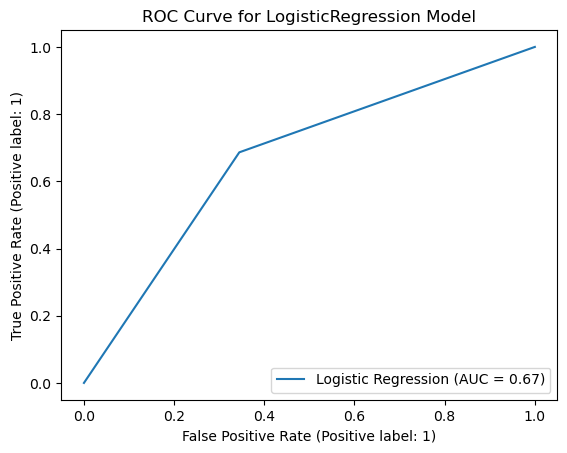

In [55]:
display = RocCurveDisplay.from_predictions(y_test, y_preds, name="Logistic Regression")
plt.title("ROC Curve for LogisticRegression Model")
plt.show()

## Therefore the final accuracy of Logistic Regression on this dataset is: 67.10 %

In [47]:
pkl.dump(model , open('models/logistic-regression-basic-text-model.pkl' , 'wb'))